In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from jupyter_bbox_widget import BBoxWidget
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost
import ipywidgets as widgets
import re

In [3]:
CLASS_LABELS = ["apple", "lemon", "banana"]
n_class = len(CLASS_LABELS)
bbox_widget = BBoxWidget(
    image='../../data/sample_img/fruits.jpeg',
    classes= CLASS_LABELS + [" ".join(["GT", l]) for l in CLASS_LABELS],
    colors=["green"] * n_class + ["orange"] * n_class,
    hide_buttons=True
    )

w_conf = widgets.FloatSlider(value=0.5, min=0, max=1., description='Confidence')
bbox_widget.attach(w_conf, name="confidence")

def format_bboxes(bboxes, classes, return_orders=False):
    orders = []
    formatted_bboxes = []
    for label in classes:
        formatted_bboxes.append([])
        for i, bbox in enumerate(bboxes):
            if label in bbox["label"]:
                if bbox["label"].startswith("GT"):
                    conf = 1 
                else:
                    conf = bbox["confidence"]
                formatted_bboxes[-1].append([bbox["x"], bbox["y"], bbox["x"]+bbox["width"], bbox["y"]+bbox["height"], conf])
                orders.append(i)
        formatted_bboxes[-1] = np.asarray(formatted_bboxes[-1], dtype=np.float32).reshape(-1, 5)
    if return_orders:
        return formatted_bboxes, orders
    return formatted_bboxes
    
def evaluate_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    otc, log = get_ot_cost(gt_bboxes, bboxes, return_matrix=True)
    return otc, log

w_out = widgets.Output()

def update_label_conf():
    idx = bbox_widget.selected_index
    cur_label = bbox_widget.bboxes[idx]["label"]

    if cur_label.startswith("GT"):
        return

    if "(" not in cur_label:
        cur_label += " ( )"

    conf = bbox_widget.bboxes[idx]["confidence"]
    new_label = re.sub(r"\(.*\)", f"({conf})", cur_label)

    bbox_widget._set_bbox_property(idx, "label", new_label)

def on_bbox_change(change):
    update_label_conf()

    w_out.clear_output(wait=True)
    otc, log = evaluate_bboxes()
    with w_out:
        print(f"{otc:.3f}")
        print(log['G'])
        
bbox_widget.observe(on_bbox_change, names=['bboxes'])

w_container = widgets.VBox([
    bbox_widget,
    w_conf,
    w_out,
])
w_container

In [4]:
evaluate_bboxes()

TypeError: get_ot_cost() missing 1 required positional argument: 'cmap_func'

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

[0.  0.5]
[0.5 0. ]


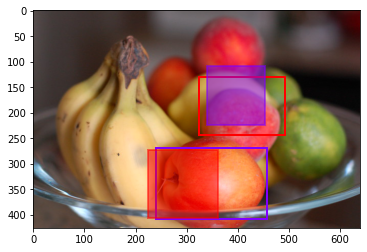

In [39]:
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm

gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
fmt_gt_bboxes, gt_bbox_indices = format_bboxes(gt_bboxes, CLASS_LABELS, return_orders=True)
bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
fmt_bboxes, bbox_indices = format_bboxes(bboxes, CLASS_LABELS, return_orders=True)
otc, log = get_ot_cost(fmt_gt_bboxes, fmt_bboxes, return_matrix=True)

img = plt.imread("data/sample_img/fruits.jpeg")
plt.imshow(img)
ax = plt.gca()

# draw gt bboxes
color = cm.rainbow(np.linspace(0, 1, len(gt_bboxes)))
for bi, c in zip(gt_bbox_indices, color):
    b = gt_bboxes[bi]
    rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, edgecolor=c, fc="None")
    ax.add_patch(rect)   

# draw bboxes
for weight, c in zip(log["G"], color):
    print(weight)
    for bi, w in zip(bbox_indices, weight):
        b = bboxes[bi]
        rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc=c, alpha=w)
        ax.add_patch(rect)   

plt.show()